In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import nibabel as nib


In [3]:
# data_dir = r'/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/checkpoints/ddp_spade_96_250403/nifti_generation2/201/train'
data_dir = r'/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/checkpoints/ddp_spade_96_250409/nifti_generation2/201/train'
# data_dir = r'/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/checkpoints/ddp_spade_96_250409/nifti_generation2/136/train'



In [4]:
import pandas as pd
from pathlib import Path

def build_summary_dataframe(out_dir):
    out_dir = Path(out_dir)
    patient_dirs = [d for d in out_dir.iterdir() if d.is_dir()]
    
    rows = []

    for patient_dir in patient_dirs:
        patient_id = patient_dir.name
        original_images = sorted(patient_dir.glob("*.nii.gz"))
        image_files = sorted((patient_dir / "images").glob("*.nii.gz")) if (patient_dir / "images").exists() else []
        label_files = sorted((patient_dir / "labels").glob("*.nii.gz")) if (patient_dir / "labels").exists() else []

        row = {
            "patient_id": patient_id,
            "original_image": [str(f) for f in original_images],
            "recon_images": [str(f) for f in image_files],
            "label_images": [str(f) for f in label_files],
        }

        rows.append(row)

    df = pd.DataFrame(rows)
    return df


In [5]:
df = build_summary_dataframe(data_dir)
df.head()

,patient_id,original_image,recon_images,label_images
0,NACT_62,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...
1,DUKE_185,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...
2,DUKE_812,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...
3,ISPY2_227055,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...
4,ISPY2_873686,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...,[/projects/0/prjs1204/projects/spadebreast2025...


In [6]:
df.shape

(948, 4)

In [18]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import center_of_mass

def load_nifti(path):
    return nib.load(str(path)).get_fdata()

def plot_patient_from_df(df_summary, patient_id, num_slices=10):
    # Find the row for the patient
    row = df_summary[df_summary["patient_id"] == patient_id]
    if row.empty:
        print(f"Patient ID {patient_id} not found in dataframe.")
        return

    # Extract paths
    original_img_path = Path(row["original_image"].values[0][2])
    recon_paths = [Path(p) for p in row["recon_images"].values[0][12:17]]  # first 5 recon variants
    label_paths = [Path(p) for p in row["label_images"].values[0]]

    # Separate original label and variants
    original_label_path = [p for p in label_paths if "_original" in p.name][0]
    label_variant_paths = [p for p in label_paths if "_original" not in p.name][:5]
    print(f"label variant name: {[label_variant_paths[i].name for i in range(len(label_variant_paths))]}")

    print(f"recon variant name: {[recon_paths[i].name for i in range(len(recon_paths))]}")
    print(f"original image name: {original_img_path.name}")

    # Load volumes
    original_img = load_nifti(original_img_path)
    original_label = load_nifti(original_label_path)
    recons = [load_nifti(p) for p in recon_paths]
    labels = [load_nifti(p) for p in label_variant_paths]

    # Find center slice of label
    com = center_of_mass(original_label)
    center_slice = int(com[-1])  # assuming last axis is Z

    # Get 10 slices centered around label
    start_slice = max(center_slice - num_slices // 2, 0)
    end_slice = start_slice + num_slices
    slice_indices = list(range(start_slice, min(end_slice, original_img.shape[-1])))

    # Set up the grid
    fig, axes = plt.subplots(len(slice_indices), 12, figsize=(24, 2.2 * len(slice_indices)))
    fig.suptitle(f"Visualization for {patient_id}", fontsize=20)

    for row, idx in enumerate(slice_indices):
        axes[row, 0].imshow(original_img[..., idx], cmap='gray')
        axes[row, 1].imshow(original_label[..., idx], cmap='gray')

        for col, recon in enumerate(recons):
            axes[row, 2 + col].imshow(recon[..., idx], cmap='gray')

        for col, label in enumerate(labels):
            axes[row, 7 + col].imshow(label[..., idx], cmap='gray')

    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


label variant name: ['duke_185_0000_deformed.nii.gz', 'duke_185_0000_dilated.nii.gz', 'duke_185_0000_dilated_deformed.nii.gz', 'duke_185_0000_eroded.nii.gz', 'duke_185_0000_eroded_deformed.nii.gz']
recon variant name: ['duke_185_0002_deformed_recon.nii.gz', 'duke_185_0002_dilated_deformed_recon.nii.gz', 'duke_185_0002_dilated_recon.nii.gz', 'duke_185_0002_eroded_deformed_recon.nii.gz', 'duke_185_0002_eroded_recon.nii.gz']
original image name: duke_185_0002.nii.gz


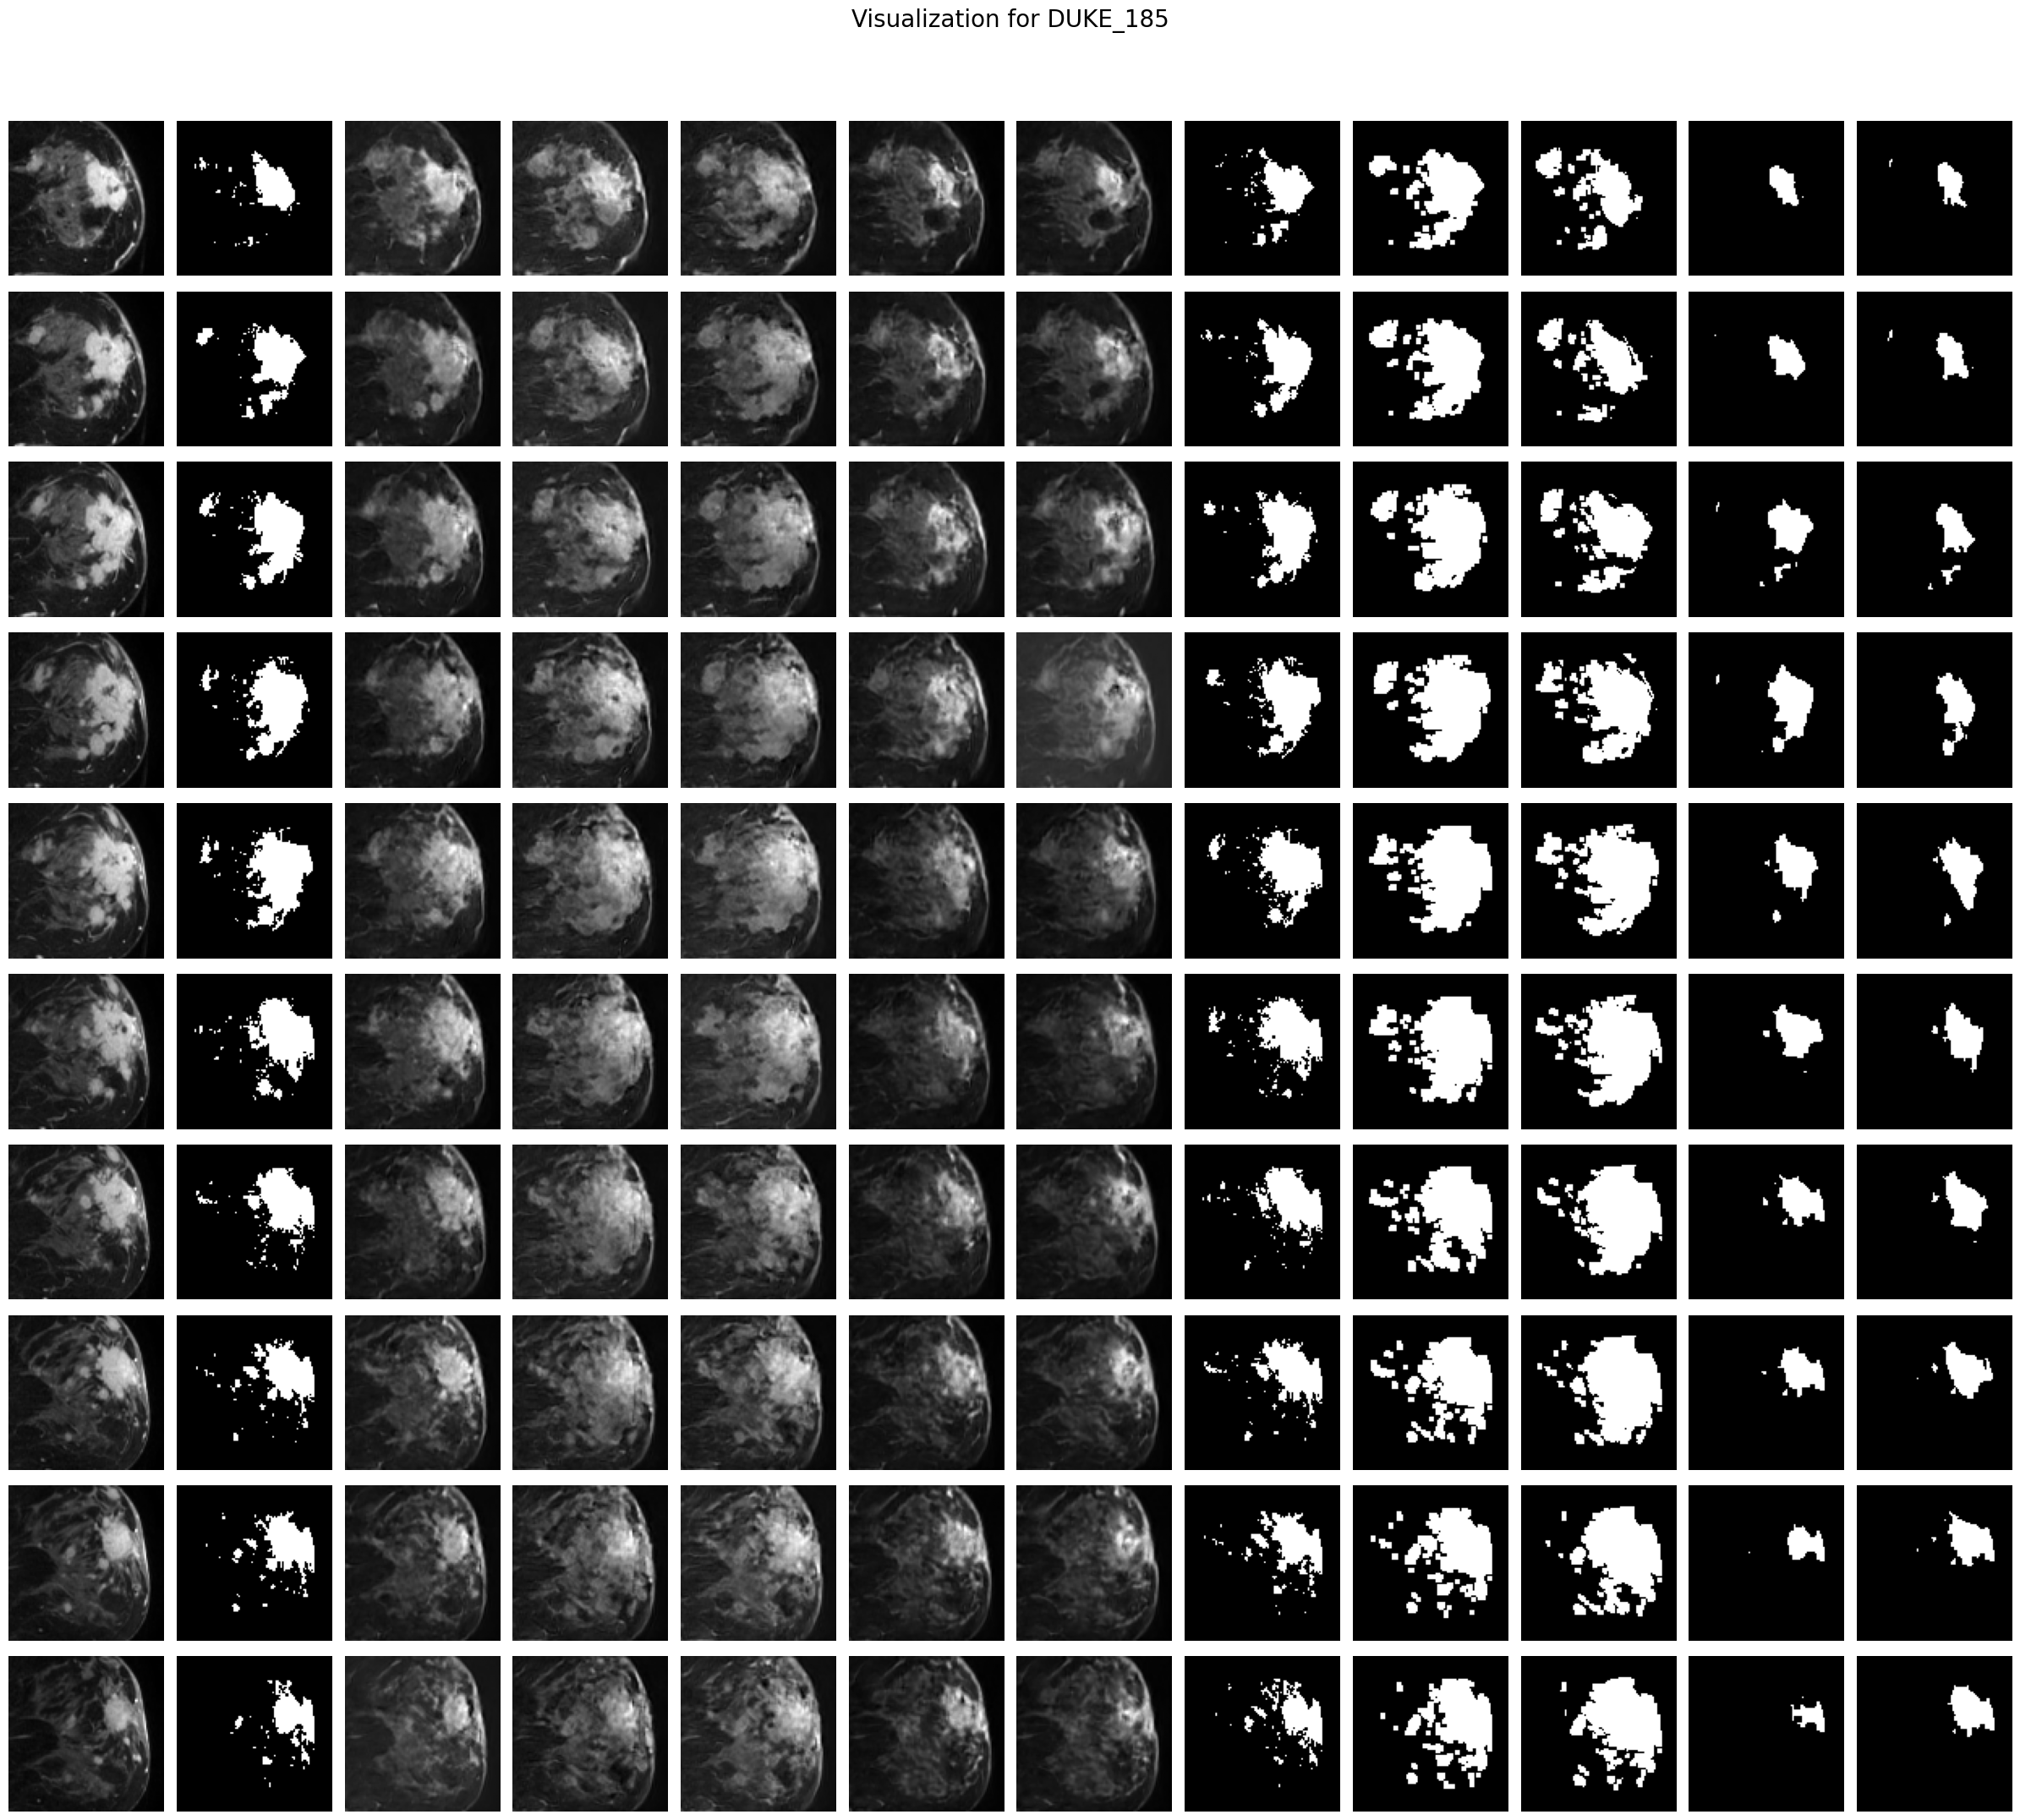

In [19]:
plot_patient_from_df(df, patient_id="DUKE_185")


In [7]:
import os
import pandas as pd

# gen_dir = "/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/checkpoints/ddp_spade_96_250403/nifti_generation/201/train"
# gen_dir =  '/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/checkpoints/ddp_spade_96_250403/nifti_generation2/201/train'
gen_dir =  '/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/checkpoints/ddp_spade_96_250409/nifti_generation2/201/train'
# df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df/stratified_96_train_valid_df.csv")
df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df/stratified_96_train_df_seg.csv")
# df = pd.read_csv("/projects/0/prjs1204/projects/breastMRI_pCR_2025/src/datasets/combined_df_list/stratified_96_train_valid_df.csv")

deforms = ["deformed_recon", "dilated_deformed_recon", "eroded_deformed_recon", "dilated_recon", "eroded_recon"]

patient_records = []

for patient_id in sorted(os.listdir(gen_dir)):
    image_ids = df[df['patient_id'] == patient_id]['image_id'].values
    image_ids = [img_id.lower() for img_id in image_ids]
    
    for deform in deforms:
        record = {
            "patient_id": patient_id,
            "deform": deform.replace("_recon", ""),
        }
        
        # Fill image paths up to 6 timepoints (pad with None if fewer)
        for i in range(6):
            if i < len(image_ids):
                image_id = image_ids[i]
                recon_path = os.path.join(gen_dir, patient_id, "images", f"{image_id}_{deform}.nii.gz")
                if os.path.exists(recon_path):
                    record[f"image_{i}"] = recon_path
                else:
                    print(f"Missing: {recon_path}")
                    record[f"image_{i}"] = None
            else:
                record[f"image_{i}"] = None

        # Optional: store full image_id list as well
        record["image_id_list"] = image_ids
        patient_records.append(record)

# Convert to DataFrame
patient_df = pd.DataFrame(patient_records)
patient_df.head()

,patient_id,deform,image_0,image_1,image_2,image_3,image_4,image_5,image_id_list
0,DUKE_001,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ..."
1,DUKE_001,dilated_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ..."
2,DUKE_001,eroded_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ..."
3,DUKE_001,dilated,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ..."
4,DUKE_001,eroded,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ..."


In [8]:
df_unique = df.drop_duplicates(subset='patient_id')

# Step 2: Merge metadata into patient_df based on patient_id
merged_df = pd.merge(patient_df, df_unique, on="patient_id", how="left")

In [9]:
print(merged_df['patient_id'].nunique())
print(merged_df.shape)
merged_df.head(40)

948
(4740, 60)


,patient_id,deform,image_0,image_1,image_2,image_3,image_4,image_5,image_id_list,image_id,...,scanner_model,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,seg_path
0,DUKE_001,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ...",DUKE_001_0000,...,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
1,DUKE_001,dilated_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ...",DUKE_001_0000,...,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
2,DUKE_001,eroded_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ...",DUKE_001_0000,...,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
3,DUKE_001,dilated,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ...",DUKE_001_0000,...,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
4,DUKE_001,eroded,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,"[duke_001_0000, duke_001_0001, duke_001_0002, ...",DUKE_001_0000,...,Avanto,11,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
5,DUKE_002,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,None,"[duke_002_0000, duke_002_0001, duke_002_0002, ...",DUKE_002_0000,...,Signa HDxt,15,326.0,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
6,DUKE_002,dilated_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,None,"[duke_002_0000, duke_002_0001, duke_002_0002, ...",DUKE_002_0000,...,Signa HDxt,15,326.0,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
7,DUKE_002,eroded_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,None,None,"[duke_002_0000, duke_002_0001, duke_002_0002, 

In [ ]:
os.makedirs("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn_0409/", exist_ok=True)
merged_df.to_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn_0409/synthetic_train.csv/combined_df_syn_0409/synthetic_train.csv")

In [11]:
import pandas as pd
import numpy as np
import os

synth_df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn_0409/synthetic_train.csv")
synth_df.head()

,Unnamed: 0,patient_id,deform,image_0,image_1,image_2,image_3,image_4,image_5,image_id_list,...,scanner_model,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,seg_path
0,0,DUKE_001,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
1,1,DUKE_001,dilated_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
2,2,DUKE_001,eroded_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
3,3,DUKE_001,dilated,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
4,4,DUKE_001,eroded,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...


In [12]:


import pandas as pd
train_df_orig = pd.read_csv('/projects/0/prjs1204/projects/breastMRI_pCR_2025/src/datasets/combined_df_list6/stratified_96_train_valid_df.csv')
train_df_orig.head(10)



,patient_id,image_0,image_1,image_2,image_3,image_4,image_5,dataset,bilateral_breast_cancer,multifocal_cancer,...,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,n_age,c_tumor_subtype,c_her2
0,DUKE_001,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,0.0,...,53.0,145.0,1.360,4.120,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,0.339623,0,1
1,DUKE_002,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,0.0,...,326.0,652.0,2.704,6.918,"[0, 165, 288, 411]",NaN,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,0.283019,2,0
2,DUKE_005,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,1.0,...,106.0,288.0,1.340,4.270,"[0, 183, 289, 398]",NaN,1.3.6.1.4.1.14519.5.2.1.3082672827908226352755...,0.283019,0,1
3,DUKE_009,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,1.0,...,231.0,462.0,2.604,6.032,"[0, 199, 314, 429]",NaN,1.3.6.1.4.1.14519.5.2.1.1955995935901349215652...,0.622642,2,0
4,DUKE_010,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,1.0,...,532.0,1064.0,2.436,5.668,"[0, 156, 255, 355]",NaN,1.3.6.1.4.1.14519.5.2.1.1390661710325525999628...,0.830189,2,0
5,DUKE_012,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,1.0,...,339.0,678.0,2.436,5.208,"[0, 185, 305, 425]",NaN,1.3.6.1.4.1.14519.5.2.1.2969057910451743020299...,0.377358,2,0
6,DUKE_022,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,1.0,...,46.0,123.0,1.400,4.140,"[0, 762, 892, 1018, 1147]",NaN,1.3.6.1.4.1.14519.5.2.1.6967082424447604620382...,0.566038,0,1
7,DUKE_032,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,DUKE,0,1.0,...,447.0,895.0,2.372,4.988,"[0, 255, 371, 487, 603]",NaN,1.3.6.1.4.1.14519.5.2.1.1425566287495064717156...,0.471698,1,0
8,DUKE_040,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,/projects/0/prjs1204/d

In [33]:
print(synth_df["dataset"].unique())
print(synth_df["dataset"].value_counts())
print(len(train_df_orig[(train_df_orig['dataset'] == 'ISPY1') ]["patient_id"].unique()))
print(len(synth_df[(synth_df['dataset'] == 'ISPY1') ]["patient_id"].unique()))
print(synth_df[(synth_df['dataset'] == 'NACT') ]["deform"].unique())

['DUKE' 'ISPY1' 'ISPY2' 'NACT']
ISPY2    3390
DUKE      735
ISPY1     410
NACT      205
Name: dataset, dtype: int64
100
82
['deformed' 'dilated_deformed' 'eroded_deformed' 'dilated' 'eroded']


In [34]:
if 'Unnamed: 0' in synth_df.columns:
    synth_df = synth_df.drop(columns=['Unnamed: 0'])
selected_deform_values = ["deformed", "dilated", "eroded"]

# filtered_df = synth_df[(synth_df['pcr'] == 1.) & (synth_df['deform'].isin(selected_deform_values))].reset_index(drop=True)

# filtered_df = synth_df[(synth_df['pcr'] == 1.) & (synth_df['deform'].isin(selected_deform_values)) & (synth_df['dataset'] != 'ISPY2')].reset_index(drop=True)
# filtered_df = synth_df[(synth_df['dataset'] != 'ISPY2') & (synth_df['deform'].isin(selected_deform_values))].reset_index(drop=True)

filtered_ISPY1 = synth_df[(synth_df['dataset'] == 'ISPY1') & (synth_df['deform'].isin(["deformed"]))].reset_index(drop=True)
print(f"size of filtered ISPY1: {filtered_ISPY1.shape}")
filtered_NACT = synth_df[(synth_df['dataset'] == 'NACT') & (synth_df['deform'].isin(["deformed", "eroded_deformed"]))].reset_index(drop=True)
print(f"size of filtered NACT: {filtered_NACT.shape}")

filtered_df = pd.concat([filtered_ISPY1, filtered_NACT], ignore_index=True)
print(f"size of filtered df: {filtered_df.shape}")

size of filtered ISPY1: (82, 60)
size of filtered NACT: (82, 60)
size of filtered df: (164, 60)


In [35]:
train_patient_ids = filtered_df['patient_id'].unique()
trained_df_filtered = train_df_orig[train_df_orig['patient_id'].isin(train_patient_ids)]
columns_to_merge = ["patient_id", "n_age", "c_tumor_subtype", "c_her2"]
first_values = trained_df_filtered[columns_to_merge].drop_duplicates(subset="patient_id", keep="first")

# Step 2: Merge with synth_df (which stays unchanged)
merged_df = filtered_df.merge(first_values, on="patient_id", how="left")


In [36]:
print(merged_df.shape)
print(f"Unique patient IDs in merged_df: {merged_df['patient_id'].nunique()}")
merged_df.head()

(164, 63)
Unique patient IDs in merged_df: 123


,patient_id,deform,image_0,image_1,image_2,image_3,image_4,image_5,image_id_list,image_id,...,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,seg_path,n_age,c_tumor_subtype,c_her2
0,ISPY1_1001,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,NaN,NaN,"['ispy1_1001_0000', 'ispy1_1001_0001', 'ispy1_...",ISPY1_1001_0000,...,54.0,4.2,8.4,"[0, 378, 707]",1984/10/13,1.3.6.1.4.1.14519.5.2.1.7695.1700.334491271566...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,0.283019,1,0
1,ISPY1_1002,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,NaN,NaN,"['ispy1_1002_0000', 'ispy1_1002_0001', 'ispy1_...",ISPY1_1002_0000,...,33.0,4.2,8.4,"[0, 423, 768]",1984/11/02,1.3.6.1.4.1.14519.5.2.1.7695.1700.200978610610...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,0.264151,1,0
2,ISPY1_1003,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,NaN,NaN,"['ispy1_1003_0000', 'ispy1_1003_0001', 'ispy1_...",ISPY1_1003_0000,...,26.0,4.2,8.4,"[0, 371, 693]",1984/11/22,1.3.6.1.4.1.14519.5.2.1.7695.1700.217966338988...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,0.490566,1,0
3,ISPY1_1004,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,NaN,NaN,"['ispy1_1004_0000', 'ispy1_1004_0001', 'ispy1_...",ISPY1_1004_0000,...,NaN,4.2,22.7,"[0, 410, 819]",1984/12/05,1.3.6.1.4.1.14519.5.2.1.7695.1700.228597508795...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,0.471698,2,0
4,ISPY1_1008,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,NaN,NaN,"['ispy1_1008_0000', 'ispy1_1008_0001', 'ispy1_...",ISPY1_1008_0000,...,39.0,4.2,20.4,"[0, 434, 727]",1985/02/15,1.3.6.1.4.1.14519.5.2.1.7695.1700.794609689168...,/projects/0/prjs1204/data/mamamia/mamamia_proc...,0.773585,1,0


In [37]:
print(merged_df["c_her2"].isna().sum())
print(merged_df["c_tumor_subtype"].isna().sum())
print(merged_df["n_age"].isna().sum())

for col in ["pcr", "deform", "dataset"]:
    unique_vals = merged_df[col].unique()
    print(f"Column: {col}")
    print("Unique values:")
    for val in unique_vals:
        print(f"  - {val}")
    print("-" * 40)


0
0
0
Column: pcr
Unique values:
  - 0.0
  - 1.0
----------------------------------------
Column: deform
Unique values:
  - deformed
  - eroded_deformed
----------------------------------------
Column: dataset
Unique values:
  - ISPY1
  - NACT
----------------------------------------


In [38]:
# merged_df.to_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train_pcr1.csv", index=False)
# merged_df.to_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train_pcr1_no_ispy2.csv", index=False)
# merged_df.to_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train_pcr1_pcr0_no_ispy2.csv", index=False)
merged_df.to_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn_0409/synthetic_train_ispy1_1_NACT_2.csv", index=False)


In [40]:
merged_df.shape

(201, 63)

In [ ]:
import pandas as pd
# df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train_pcr1.csv")
# df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train.csv")



# df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train_pcr1_no_ispy2.csv")
df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train_pcr1_pcr0_no_ispy2.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by tumor_subtype and pcr, then count unique patient_id values
unique_patient_counts = df.groupby(['tumor_subtype', 'pcr', "dataset"])['patient_id'].nunique()

# Convert to DataFrame for plotting
plot_data = unique_patient_counts.unstack()

# Plot
ax = plot_data.plot(kind='bar', figsize=(10, 6))

plt.title('Number of Unique Patients per Tumor Subtype and pCR Status')
plt.xlabel('Tumor Subtype')
plt.ylabel('Number of Unique Patients')
plt.xticks(rotation=45)
plt.legend(title='pCR')

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


KeyError: 'tumor_subtype'

In [5]:
df.shape

(4740, 61)

In [33]:
# df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train.csv")
df = pd.read_csv('/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df/stratified_96_train_df_seg.csv')
# df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df/stratified_96_test_df.csv")

In [26]:
df_no_ispy2 = df[df['dataset'] != 'ISPY2'].drop_duplicates(subset="patient_id", keep="first")


In [27]:
print(df_no_ispy2['dataset'].value_counts())


DUKE     91
ISPY1    67
NACT     17
Name: dataset, dtype: int64


In [28]:
group_counts = (
    df_no_ispy2
    .groupby(['dataset', 'tumor_subtype', 'pcr'])
    .size()
    .reset_index(name='count')
)

In [29]:
print(group_counts.sort_values(by='count', ascending=False))


   dataset tumor_subtype  pcr  count
2     DUKE       Luminal  0.0     34
8    ISPY1       Luminal  0.0     27
0     DUKE       HER2pos  0.0     16
5     DUKE     TripleNeg  1.0     13
6    ISPY1       HER2pos  0.0     12
10   ISPY1     TripleNeg  0.0     12
1     DUKE       HER2pos  1.0     11
4     DUKE     TripleNeg  0.0     11
7    ISPY1       HER2pos  1.0      9
3     DUKE       Luminal  1.0      6
13    NACT       Luminal  0.0      5
15    NACT     TripleNeg  0.0      5
11   ISPY1     TripleNeg  1.0      3
9    ISPY1       Luminal  1.0      2
12    NACT       HER2pos  1.0      2
14    NACT       Luminal  1.0      1


In [26]:
synth_df = pd.read_csv("/projects/0/prjs1204/projects/spadebreast2025/src/spadebreast/dataset/combined_df_syn/synthetic_train.csv")
synth_df.head()

,Unnamed: 0,patient_id,deform,image_0,image_1,image_2,image_3,image_4,image_5,image_id_list,...,scanner_model,high_bit,window_center,window_width,echo_time,repetition_time,acquisition_times,acquisition_date,tcia_series_uid,seg_path
0,0,DUKE_001,deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
1,1,DUKE_001,dilated_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
2,2,DUKE_001,eroded_deformed,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
3,3,DUKE_001,dilated,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...
4,4,DUKE_001,eroded,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,/projects/0/prjs1204/projects/spadebreast2025/...,NaN,"['duke_001_0000', 'duke_001_0001', 'duke_001_0...",...,Avanto,11,53.0,145.0,1.36,4.12,"[0, 584, 714, 846, 977]",NaN,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,/projects/0/prjs1204/data/mamamia/mamamia_proc...


In [47]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def plot_patient_images_with_deforms(df, patient_id, deform_types):
    # Filter rows for the specific patient and selected deformation types
    patient_rows = df[(df['patient_id'] == patient_id) & (df['deform'].isin(deform_types))]
    
    if patient_rows.empty:
        print(f"No matching data found for patient_id: {patient_id} with deforms: {deform_types}")
        return

    fig, axs = plt.subplots(nrows=len(patient_rows), figsize=(12, 4 * len(patient_rows)))
    if len(patient_rows) == 1:
        axs = [axs]  # Ensure axs is iterable

    fig.suptitle(f'Patient ID: {patient_id}', fontsize=16)

    for d_idx, (_, row) in enumerate(patient_rows.iterrows()):
        image_paths = [row[f'image_{i}'] for i in range(3)]
        deform_label = row['deform']
        concat_rows = []

        for slice_num in range(8):
            slice_idx = slice_num * 10
            row_slices = []
            for path in image_paths:
                img = nib.load(path)
                data = img.get_fdata()
                if slice_idx < data.shape[2]:
                    row_slices.append(data[:, :, slice_idx])
                else:
                    row_slices.append(np.zeros_like(data[:, :, 0]))  # Blank if out of bounds
            # Concatenate image_0, image_1, image_2 horizontally
            row_concat = np.concatenate(row_slices, axis=0)
            concat_rows.append(row_concat)

        # Concatenate 8 rows vertically
        full_image = np.concatenate(concat_rows, axis=1)
        axs[d_idx].imshow(full_image, cmap='gray')
        axs[d_idx].axis('off')
        axs[d_idx].set_title(f'Deformation: {deform_label}', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


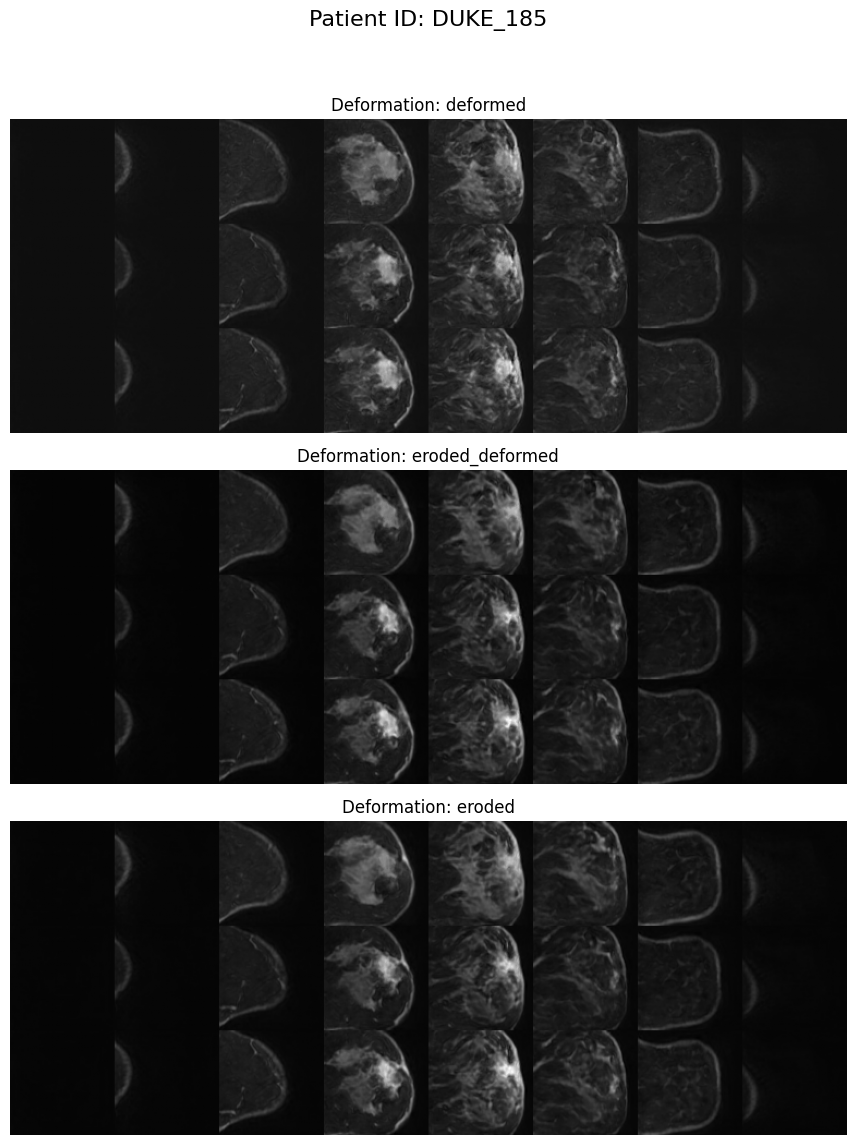

In [51]:
patient_id = 'DUKE_185'
plot_patient_images_with_deforms(synth_df, patient_id, ['deformed', 'eroded', 'eroded_deformed'])


In [49]:
train_df_orig = pd.read_csv('/projects/0/prjs1204/projects/breastMRI_pCR_2025/src/datasets/combined_df_list6/stratified_96_train_valid_df.csv')

In [53]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def plot_patient_images(df, patient_id):
    # Filter rows for the specific patient and selected deformation types
    patient_rows = df[(df['patient_id'] == patient_id)]
    
    if patient_rows.empty:
        print(f"No matching data found for patient_id: {patient_id}")
        return

    fig, axs = plt.subplots(nrows=len(patient_rows), figsize=(12, 4 * len(patient_rows)))
    if len(patient_rows) == 1:
        axs = [axs]  # Ensure axs is iterable

    fig.suptitle(f'Patient ID: {patient_id}', fontsize=16)

    for d_idx, (_, row) in enumerate(patient_rows.iterrows()):
        image_paths = [row[f'image_{i}'] for i in range(3)]

        concat_rows = []

        for slice_num in range(8):
            slice_idx = slice_num * 10
            row_slices = []
            for path in image_paths:
                img = nib.load(path)
                data = img.get_fdata()
                if slice_idx < data.shape[2]:
                    row_slices.append(data[:, :, slice_idx])
                else:
                    row_slices.append(np.zeros_like(data[:, :, 0]))  # Blank if out of bounds
            # Concatenate image_0, image_1, image_2 horizontally
            row_concat = np.concatenate(row_slices, axis=0)
            concat_rows.append(row_concat)

        # Concatenate 8 rows vertically
        full_image = np.concatenate(concat_rows, axis=1)
        axs[d_idx].imshow(full_image, cmap='gray')
        axs[d_idx].axis('off')
        

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


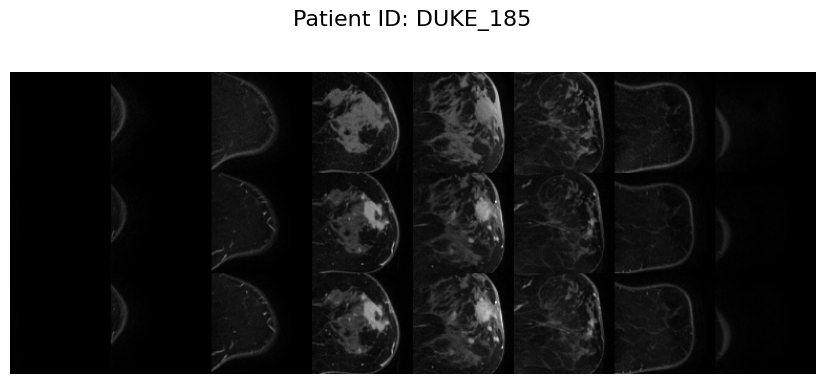

In [54]:
plot_patient_images(train_df_orig, patient_id)